In [1]:
import sys
from os import symlink
import pickle
import tempfile
from tqdm import tqdm
import numpy as np
import cupy as cp
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from one.api import ONE
import scipy
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import spikeglx
import neuropixel
from brainbox.io.one import SpikeSortingLoader
from ibldsp.voltage import (
    saturation, destripe_lfp, 
    detect_bad_channels, 
    interpolate_bad_channels, 
    _get_destripe_parameters,
    decompress_destripe_cbin
)
from ibldsp.utils import rms, fcn_cosine
from ibldsp.waveforms import compute_spike_features

In [2]:
BANDS = {'delta': [0, 4], 'theta': [4, 10], 'alpha': [8, 12], 'beta': [15, 30], 'gamma': [30, 90], 'lfp': [0, 90]}

def _get_power_in_band(fscale, period, band):
    band = np.array(band)
    fweights = fcn_cosine([-np.diff(band), 0])(-abs(fscale - np.mean(band)))
    p = 10 * np.log10(np.sum(period * fweights / np.sum(fweights), axis=-1))  # dB relative to v/sqrt(Hz)
    return p

def lf(data, fs, bands=None):
    """
    Computes the LF features from a numpy array
    :param data: numpy array with the data (channels, samples)
    :param fs: sampling interval (Hz)
    :param bands: dictionary with the bands to compute (default: BANDS constant)
    :return: pandas dataframe with the columns ['channel', 'rms_lf', 'psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta',
       'psd_gamma', 'psd_lfp']
    """
    bands = BANDS if bands is None else bands
    nc = data.shape[0]  # number of channels
    fscale, period = scipy.signal.periodogram(data, fs)
    df_chunk = pd.DataFrame()
    df_chunk['channel'] = np.arange(nc)
    df_chunk['rms_lf'] = rms(data, axis=-1)
    for b in BANDS:
        df_chunk[f"psd_{b}"] = _get_power_in_band(fscale, period, bands[b])
    return df_chunk['psd_lfp']

In [3]:
def load_trials_and_mask(
        one, eid, min_rt=0.08, max_rt=2., nan_exclude='default', min_trial_len=None,
        max_trial_len=None, exclude_unbiased=False, exclude_nochoice=True, sess_loader=None):

    trials = one.load_object(eid, 'trials', collection='alf')
    length = len(trials['choice'])
    query = np.full(length, True)
    
    if nan_exclude == 'default':
        nan_exclude = [
            'stimOn_times',
            'choice',
            'feedback_times',
            'probabilityLeft',
            'firstMovement_times',
            'feedbackType'
        ]

    # Create a mask for trials to exclude
    # Remove trials that are outside the allowed reaction time range
    if min_rt is not None:
        condition = (trials['firstMovement_times'] - trials['stimOn_times']) > min_rt
        query &= condition

    if max_rt is not None:
        condition = (trials['firstMovement_times'] - trials['stimOn_times']) < max_rt
        query &= condition
    # Remove trials that are outside the allowed trial duration range
    if min_trial_len is not None:
        condition = (trials['feedback_times'] - trials['goCue_times']) > min_trial_len
        query &= condition
    if max_trial_len is not None:
        condition = (trials['feedback_times'] - trials['goCue_times']) < max_trial_len
        query &= condition
    # Remove trials with nan in specified events
    for event in nan_exclude:
        condition = ~np.isnan(trials[event])
        query &= condition
    # Remove trials in unbiased block at beginning
    if exclude_unbiased:
        condition = trials['probabilityLeft'] != 0.5
        query &= condition
    # Remove trials where animal does not respond
    if exclude_nochoice:
        condition = trials['choice'] != 0
        query &= condition
    # If min_rt was None we have to clean up the string
    if min_rt is None:
        query = query[3:]

    # Create mask
    mask = query

    return trials, mask

In [4]:
# ---------
# load data
# ---------

PATH_CACHE = Path("/scratch/bcxj/yzhang39")
one = ONE(
    base_url="https://openalyx.internationalbrainlab.org", 
    cache_dir=PATH_CACHE
)

# eid = 'db4df448-e449-4a6f-a0e7-288711e7a75a'
pid = '18be19f9-6ca5-4fc8-9220-ba43c3e75905'
eid, probe = one.pid2eid(pid)
# pid, probes = one.eid2pid(eid)
# pid=pid[0]
# probe = probes[0]

ssl = SpikeSortingLoader(pid=pid, one=one)
channels = ssl.load_channels()

stimOn_times = one.load_object(ssl.eid, 'trials', collection='alf')['stimOn_times']

sr_lf = ssl.raw_electrophysiology(band='lf', stream=False) 
nc = sr_lf.nc - sr_lf.nsync
h = sr_lf.geometry
ncv = h["sample_shift"].size

trial_window = [-0.5, 1.5] 

trials, mask = load_trials_and_mask(one, eid)
stimOn_times = stimOn_times[mask]

2024-07-22 15:02:47 WARNING  spikeglx.py:645  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


In [ ]:
import spikeinterface.preprocessing as si
from spikeinterface.extractors.iblextractors import IblRecordingExtractor
from spikeinterface.preprocessing import phase_shift
rec_si_stream = IblRecordingExtractor(pid=pid, stream_name=f"{probe}.lf", one=one, stream=True)
rec_phs = phase_shift(rec_si_stream) # channel rephasing

rec_bp = si.bandpass_filter(rec_phs, freq_min=0.5, freq_max=250)
bad_chans, labels = si.detect_bad_channels(rec_bp, psd_hf_threshold=1.4, num_random_chunks=100, seed=0)

In [9]:
detect_kwargs = {
    "lf": {"fs": sr_lf.fs, "psd_hf_threshold": 1.4, 'similarity_threshold': (-0.25, 1)},
}
channel_labels, _ = detect_bad_channels(
    sr_lf[10000:50000,:].T, **detect_kwargs['lf']
)

In [10]:
# ----------
# preprocess
# ----------

band = "lf"
detect_kwargs = {
    "lf": {"fs": sr_lf.fs, "psd_hf_threshold": 1.4},
}

lfp_data = []
for trial_idx in tqdm(range(len(stimOn_times)), total=len(stimOn_times)):
    t_event = stimOn_times[trial_idx]
    s_event = int(ssl.samples2times(t_event, direction='reverse'))

    # for NP probes always 12 because AP is sampled at 12x the frequency of LF
    sample_lf = s_event // 12
    first, last = (
        int(trial_window[0] * sr_lf.fs) + sample_lf, 
        int(trial_window[1] * sr_lf.fs + sample_lf)
    )
    chunk = rec_bp.frame_slice(start_frame=first, end_frame=last) 
    rec_prec = si.interpolate_bad_channels(chunk, bad_chans)
    rec_prec = si.common_reference(rec_prec, reference='global', operator='median')
    lfp_data.append(rec_prec.get_traces().T)
    
lfp_data = np.array(lfp_data)
print(lfp_data.shape)

 39%|███▊      | 73/189 [00:50<00:46,  2.52it/s]

Downloading: /scratch/bcxj/yzhang39/cache/lf/angelakilab/Subjects/NYU-45/2021-07-19/001/raw_ephys_data/probe01/chunk_001188_to_001191/_spikeglx_ephysData_g0_t0.imec1.lf.cac2a937-561c-4c15-8f82-5039e94fa74d.cbin Bytes: 2578151



  0%|          | 0/2.45871639251709 [00:00<?, ?it/s]
100%|██████████| 2.45871639251709/2.45871639251709 [00:00<00:00,  6.95it/s]
100%|██████████| 189/189 [01:43<00:00,  1.83it/s]


(189, 384, 5000)


In [11]:
lfp_data = lfp_data.transpose(0,2,1)

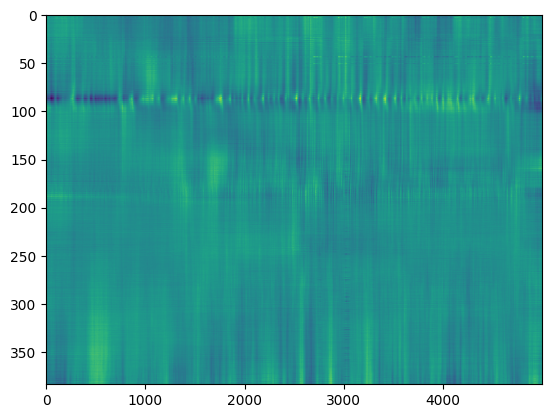

In [12]:
plt.imshow(lfp_data[0].T, aspect='auto');

In [13]:
# ------------------
# feature extraction
# ------------------

import warnings 
warnings.filterwarnings('ignore') 

n_split = 5
data_splits = np.array(np.split(lfp_data, n_split, axis=1))
data_splits = np.transpose(data_splits, (1, 3, 0, 2))

n_trials = data_splits.shape[0]

power_bands = []
for trial_idx in tqdm(range(n_trials), total=n_trials):
    tmp = []
    for tbin_idx in range(n_split):
        tmp.append(
            np.array(
                lf(data_splits[trial_idx,:,tbin_idx,:], fs=sr_lf.fs)
            )
        )
    power_bands.append(tmp)
    
power_bands = np.transpose(power_bands, (0,2,1))
print(power_bands.shape)

100%|██████████| 189/189 [00:09<00:00, 20.87it/s]

(189, 384, 5)


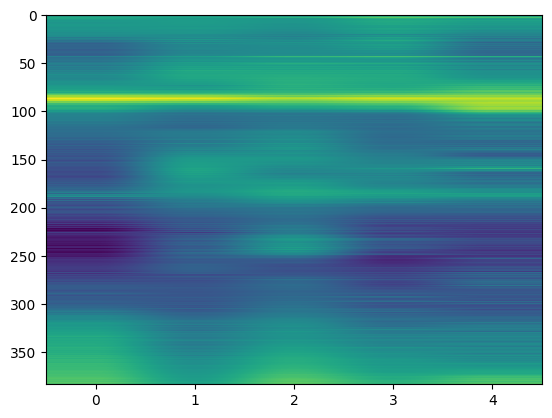

In [14]:
plt.imshow(power_bands[0], aspect='auto');

In [15]:
# --------
# decoding
# --------

trials = one.load_object(eid, 'trials', collection='alf')
X = power_bands.copy()
Y = trials['choice'][mask]

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import balanced_accuracy_score
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

seed = 666
skf = KFold(n_splits=5, shuffle=True, random_state=seed)
grid={"C":[10000,1000, 100, 10, 1,1e-1,1e-2,1e-3,1e-4,1e-5], "penalty":["l2"]}
metrics = []
for fold_idx, (train, test) in enumerate(skf.split(X, Y)):

    train_X, test_X = X[train], X[test]
    train_Y, test_Y = Y[train], Y[test]
    train_X = train_X.reshape(train_X.shape[0], -1)
    test_X = test_X.reshape(test_X.shape[0], -1)

    clf=LogisticRegression()
    clf=GridSearchCV(clf,grid,cv=5)
    clf.fit(train_X,train_Y)
    print("tuned hpyerparameters :(best parameters) ",clf.best_params_['C'])
    train_pred = clf.predict(train_X)
    train_prob = clf.predict_proba(train_X)[:, 1]
    test_pred = clf.predict(test_X)
    test_prob = clf.predict_proba(test_X)[:, 1]

    train_acc = accuracy_score(train_Y, train_pred)
    test_acc = accuracy_score(test_Y, test_pred)
    train_auc = roc_auc_score(train_Y, train_prob)
    test_auc = roc_auc_score(test_Y, test_prob)
    b_test_acc = balanced_accuracy_score(test_Y, test_pred)
    metrics.append([test_acc, test_auc, b_test_acc])
    print("train test acc", train_acc,',', test_acc)
    print("train test auc", train_auc,',', test_auc)
metrics = np.array(metrics)

print('Test Acc = ', np.mean(metrics,axis = 0)[0], 'Test AUC = ', np.mean(metrics,axis = 0)[1], 'Test Balanced ACC = ', np.mean(metrics,axis = 0)[2])

tuned hpyerparameters :(best parameters)  100
train test acc 1.0 , 0.868421052631579
train test auc 1.0 , 0.9083333333333333
tuned hpyerparameters :(best parameters)  10
train test acc 1.0 , 0.6578947368421053
train test auc 1.0 , 0.8809523809523809
tuned hpyerparameters :(best parameters)  0.01
train test acc 1.0 , 0.868421052631579
train test auc 1.0 , 0.9307479224376731
tuned hpyerparameters :(best parameters)  10000
train test acc 1.0 , 0.8157894736842105
train test auc 1.0 , 0.9019886363636364
tuned hpyerparameters :(best parameters)  10000
train test acc 1.0 , 0.8918918918918919
train test auc 1.0 , 0.9347826086956521
Test Acc =  0.8204836415362731 Test AUC =  0.9113609763565351 Test Balanced ACC =  0.8246025554663998
